In [ ]:
%%capture
!pip install datasets
import sys
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from numpy.random import RandomState
import tensorflow as tf
seed = 0

torch.manual_seed(seed)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/nlp_hw7")

In [ ]:
data = pd.read_csv('Emotion_final.csv', sep=',')
data.head()


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
rng = RandomState()

train_data = data.sample(frac=0.8, random_state=rng)
test_data = data.loc[~data.index.isin(train_data.index)]

In [ ]:
train_data.head()

,Text,Emotion
6620,i feel very unfortunate to have only in the la...,sadness
8497,i just hope we can help him feel less afraid a...,fear
11811,i don t want to feel dissatisfied i want to fe...,anger
9306,i feel like i ve been put in a bag and shaken ...,fear
17882,i feel watching him grow into a self assured l...,happy


In [ ]:
test_data.head()

,Text,Emotion
3,i am ever feeling nostalgic about the fireplac...,love
16,i didnt really feel that embarrassed,sadness
18,i started feeling sentimental about dolls i ha...,sadness
19,i now feel compromised and skeptical of the va...,fear
34,i can t imagine a real life scenario where i w...,happy


# Data Preparation
### Label Encoding
Convert each label into a crresponding integer.

In [ ]:
train_data["Emotion"] = train_data["Emotion"].astype('category')
train_data["Emotion_label"] = train_data["Emotion"].cat.codes
train_data.head()

,Text,Emotion,Emotion_label
6620,i feel very unfortunate to have only in the la...,sadness,4
8497,i just hope we can help him feel less afraid a...,fear,1
11811,i don t want to feel dissatisfied i want to fe...,anger,0
9306,i feel like i ve been put in a bag and shaken ...,fear,1
17882,i feel watching him grow into a self assured l...,happy,2


In [ ]:
%%capture
test_data["Emotion"] = test_data["Emotion"].astype('category')
test_data["Emotion_label"] = test_data["Emotion"].cat.codes
test_data.head()

<ipython-input-15-eafe5dccda80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Emotion"] = test_data["Emotion"].astype('category')
<ipython-input-15-eafe5dccda80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Emotion_label"] = test_data["Emotion"].cat.codes


,Text,Emotion,Emotion_label
3,i am ever feeling nostalgic about the fireplac...,love,3
16,i didnt really feel that embarrassed,sadness,4
18,i started feeling sentimental about dolls i ha...,sadness,4
19,i now feel compromised and skeptical of the va...,fear,1
34,i can t imagine a real life scenario where i w...,happy,2


# Tokenization and Sampling

In [ ]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["Text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(10000);

# Constructing Vocabulary and Index-Word Mapping

In [ ]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  


In [ ]:
# construct vocab and indexing
inputs = ConstructVocab(data["Text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['', '!', '"', "&mdash'How;", "'", "'S", "'d", "'ll", "'m", "'re"]

# Converting Data into Tensors
### For convenience we would like to convert the data into tensors.

In [ ]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["Text"].values.tolist()]

In [ ]:
# examples of what is in the input tensors
input_tensor[0:2]

[[6059, 1096, 4768, 1973, 10996, 2199, 11966, 3984, 8780],
 [6059,
  3899,
  4768,
  9806,
  11984,
  8369,
  1897,
  13054,
  5018,
  1149,
  988,
  6059,
  3925,
  11533,
  4459,
  9369,
  11902,
  4768,
  8236,
  10616,
  3511,
  5320,
  1298,
  8210,
  9324]]

# Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

64


In [ ]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [ ]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [ ]:
input_tensor[0:2]

[array([ 6059,  1096,  4768,  1973, 10996,  2199, 11966,  3984,  8780,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([ 6059,  3899,  4768,  9806, 11984,  8369,  1897, 13054,  5018,
         1149,   988,  6059,  3925, 11533,  4459,  9369, 11902,  4768,
         8236, 10616,  3511,  5320,  1298,  8210,  9324,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

# Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [ ]:
from sklearn import preprocessing
### convert targets to one-hot encoding vectors
emotions = list(set(data.Emotion.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['Emotion']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

In [ ]:
data[0:2]

,Text,Emotion,token_size
14952,i always feel boosted spiritually but totally ...,sadness,9
8774,i do feel resentful towards other bloggers wri...,anger,25


In [ ]:
get_emotion = lambda t: np.argmax(t)

In [ ]:
get_emotion(target_tensor[0])

4

In [ ]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'happy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [ ]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

# Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [ ]:
from sklearn.model_selection import train_test_split
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(8000, 8000, 1000, 1000, 1000, 1000)

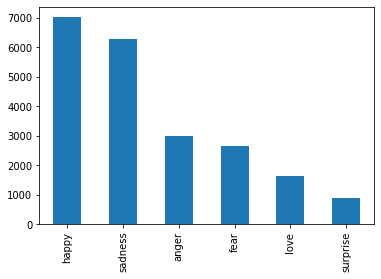

In [ ]:
# load data
data = pd.read_csv('Emotion_final.csv', sep=',')
data.Emotion.value_counts().plot.bar()

# Data Loader
We can also laod the data into a data loader, which makes it easy to manipulate the data, create batches, and apply further transformations. In PyTorch we can use the DataLoader function.

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [ ]:
from torch.utils.data import Dataset, DataLoader
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset.batch_size

64

# Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a simple recurrent neural network.


In [ ]:
import torch.nn as nn
class EmoRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoRNN, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.rnn = nn.RNN(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.rnn(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden 

# Pretesting model
we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are the expected ones.

In [ ]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoRNN(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([64, 64])
torch.Size([64, 6])


In [ ]:
import time

# Training the Model
Now that we have tested the model, it is time to train it. We will define out optimization algorithm, learnin rate, and other necessary information to train the model.

In [ ]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoRNN(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3016
Epoch 1 Batch 100 Val. Loss 0.2594
Epoch 1 Loss 0.2770 -- Train Acc. 30.3000 -- Val Acc. 33.2292
Time taken for 1 epoch 295.6365988254547 sec

Epoch 2 Batch 0 Val. Loss 0.2587
Epoch 2 Batch 100 Val. Loss 0.2066
Epoch 2 Loss 0.2296 -- Train Acc. 47.1250 -- Val Acc. 66.5625
Time taken for 1 epoch 291.2494070529938 sec

Epoch 3 Batch 0 Val. Loss 0.1610
Epoch 3 Batch 100 Val. Loss 0.0639
Epoch 3 Loss 0.0948 -- Train Acc. 81.1500 -- Val Acc. 82.8125
Time taken for 1 epoch 290.7948668003082 sec

Epoch 4 Batch 0 Val. Loss 0.0477
Epoch 4 Batch 100 Val. Loss 0.0486
Epoch 4 Loss 0.0390 -- Train Acc. 91.6625 -- Val Acc. 86.7708
Time taken for 1 epoch 292.4476070404053 sec

Epoch 5 Batch 0 Val. Loss 0.0259
Epoch 5 Batch 100 Val. Loss 0.0197
Epoch 5 Loss 0.0178 -- Train Acc. 96.1000 -- Val Acc. 85.7292
Time taken for 1 epoch 290.25717639923096 sec

Epoch 6 Batch 0 Val. Loss 0.0118
Epoch 6 Batch 100 Val. Loss 0.0154
Epoch 6 Loss 0.0105 -- Train Acc. 97.8125 -- Val Ac

# Evaluation on the Testing Data
Now we will evaluate the model with the holdout dataset.

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cpu" # we don't need GPU to do testing
model.to("cpu")
i=0
for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0), lens, device)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.detach().numpy() / TEST_N_BATCH)

Test Accuracy:  85.10416666666667
